# Urban Sound Classification using Deep Learning

## 1. Project Overview

**Type of Learning**: Supervised Deep Learning

**Algorithms**: Deep Neural Networks (MLP, CNN, LSTM) with Hyperparameter Tuning

**Task**: Multi-class Classification of Urban Sounds

This project focuses on classifying urban sounds into 10 different categories using deep learning approaches. The UrbanSound8K dataset contains 8732 labeled sound excerpts from urban environments, which we use to train and evaluate various neural network architectures.

## 2. Motivation and Goal

**Motivation**: Urban sound classification has important applications in:
- Smart city monitoring and noise pollution analysis
- Audio surveillance systems
- Environmental sound recognition for IoT devices
- Audio-based context awareness in mobile applications

**Goal**: The goal is to investigate which of the three deep learning classification models we learned in class applies the best to audio tasks. My initial guess is RNNs, as audio is sequential by nature, as long as the temporal sequence preserved by the preprocessing.

## 3. Dataset Source and Citation

**Dataset**: UrbanSound8K Dataset

**Source**: [https://urbansounddataset.weebly.com/urbansound8k.html](https://urbansounddataset.weebly.com/urbansound8k.html)

**Citation**:
J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research",
22nd ACM International Conference on Multimedia, Orlando SA, Nov. 2014.

Dataset compiled by Justin Salamon, Christopher Jacoby and Juan Pablo Bello. All files are excerpts of recordings
uploaded to www.freesound.org. Please see FREESOUNDCREDITS.txt in the repository for an attribution list.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras_tuner as kt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-10-02 15:08:33.557022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset path
DATASET_PATH = "UrbanSound8K"
METADATA_FILE = os.path.join(DATASET_PATH, "metadata", "UrbanSound8K.csv")

# Load metadata
metadata = pd.read_csv(METADATA_FILE)
print("Dataset loaded successfully!")
print("Dataset shape:", metadata.shape)

Dataset loaded successfully!
Dataset shape: (8732, 8)


## 4. Dataset Description
**Data Size**:
- Total sound files: 8,732 excerpts
- Classes: 10 urban sound categories
- Typical length: <= 4 seconds duration
- Format: WAV files organized in 10 folds for cross-validation

The sampling rate, bit depth, and number of channels are the same as those of the original file uploaded to Freesound (and hence may vary from file to file).

In [3]:
# Display basic dataset information
print("Total number of audio files:", len(metadata))
print("Number of unique classes:", metadata['class'].nunique())
print("Classes:", sorted(metadata['class'].unique()))

# Display dataset structure
display(metadata.head())

# Display dataset columns
print("Dataset columns:", metadata.columns.tolist())

Total number of audio files: 8732
Number of unique classes: 10
Classes: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Dataset columns: ['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class']


## 5. EXPLORATORY DATA ANALYSIS (EDA)

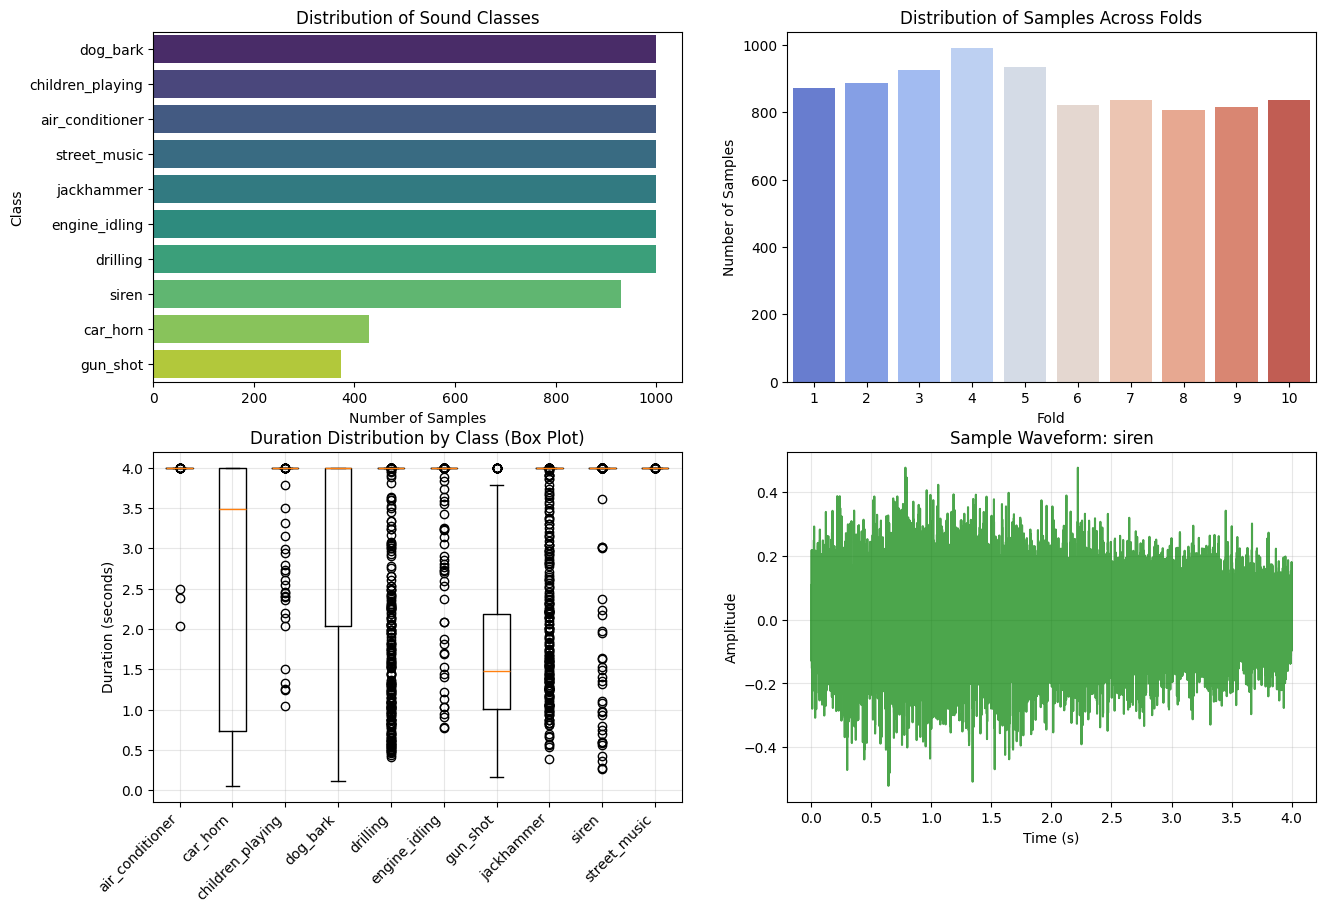

In [4]:
# 5.1 Label Distribution Analysis
plt.figure(figsize=(15, 10))

# Class distribution
plt.subplot(2, 2, 1)
class_counts = metadata['class'].value_counts()
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')
plt.title('Distribution of Sound Classes')
plt.xlabel('Number of Samples')
plt.ylabel('Class')

# Fold distribution
plt.subplot(2, 2, 2)
fold_counts = metadata['fold'].value_counts().sort_index()
sns.barplot(x=fold_counts.index, y=fold_counts.values, palette='coolwarm')
plt.title('Distribution of Samples Across Folds')
plt.xlabel('Fold')
plt.ylabel('Number of Samples')

# Duration statistics
plt.subplot(2, 2, 3)
durations_by_class = []
class_names = []
for class_name in sorted(metadata['class'].unique()):
    class_records = metadata[metadata['class'] == class_name]
    class_durations = class_records['end'] - class_records['start']
    durations_by_class.append(class_durations)
    class_names.append(class_name)

plt.boxplot(durations_by_class, labels=class_names)
plt.xticks(rotation=45, ha='right')
plt.title('Duration Distribution by Class (Box Plot)')
plt.ylabel('Duration (seconds)')
plt.grid(True, alpha=.3)

# Sample audio file analysis
plt.subplot(2, 2, 4)
# Analyze a sample file to show waveform diversity
sample_file = metadata.sample(1, random_state=42).iloc[0]
file_path = os.path.join(DATASET_PATH, "audio", f"fold{sample_file['fold']}", sample_file['slice_file_name'])
audio, sr = librosa.load(file_path, sr=22050)
time_axis = np.linspace(0, len(audio)/sr, len(audio))
plt.plot(time_axis, audio, color='green', alpha=.7)
plt.title('Sample Waveform: %s' % sample_file["class"])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=.3)

plt.show()

### 5.1 Observations

Most classes seem to have around 1000 samples a few with a significantly lower number of samples. Even then, this does not warrant resampling as the overall distribution is mostly balanced.

Another important observation is that the folds do not contain the exact same number of samples. In fact, even if each contained the same number of samples, the *amount of data* would not be the same as the duration varies between samples. An important implication is that for a fair comparison, 10-fold cross-validation is necessary.

It is also interesting to note that except for car horns and gun shots, all clips have a median of around 4.0. Gun shots have a median way below. While it is not used here, I suspect that including the duration as a feature/parameter while training would improve the scores of these two classes.

In [5]:
# 5.2 Audio Characteristics Analysis

# Analyze a few sample files to demonstrate audio properties
sample_analysis = []
for _, row in metadata.sample(20, random_state=42).iterrows():
    file_path = os.path.join(DATASET_PATH, "audio", f"fold{row['fold']}", row['slice_file_name'])
    audio, sr = librosa.load(file_path, sr=None)
    duration = len(audio) / sr
    sample_analysis.append({
        'class': row['class'],
        'duration': duration,
        'sample_rate': sr,
        'samples': len(audio),
        'max_amplitude': np.max(np.abs(audio))
    })

pd.DataFrame(sample_analysis).style.set_caption("Audio characteristics")

,class,duration,sample_rate,samples,max_amplitude
0,siren,4.000000,44100,176400,0.522919
1,street_music,4.000000,48000,192000,0.391418
2,drilling,4.000000,44100,176400,0.573761
3,siren,4.000000,44100,176400,0.690353
4,dog_bark,4.000000,44100,176400,1.000000
5,jackhammer,3.247490,96000,311759,0.667306
6,children_playing,4.000000,48000,192000,0.480023
7,children_playing,4.000000,44100,176400,0.168259
8,drilling,2.046729,48000,98243,0.999908
9,dog_bark,4.000000,44100,176400,0.312347


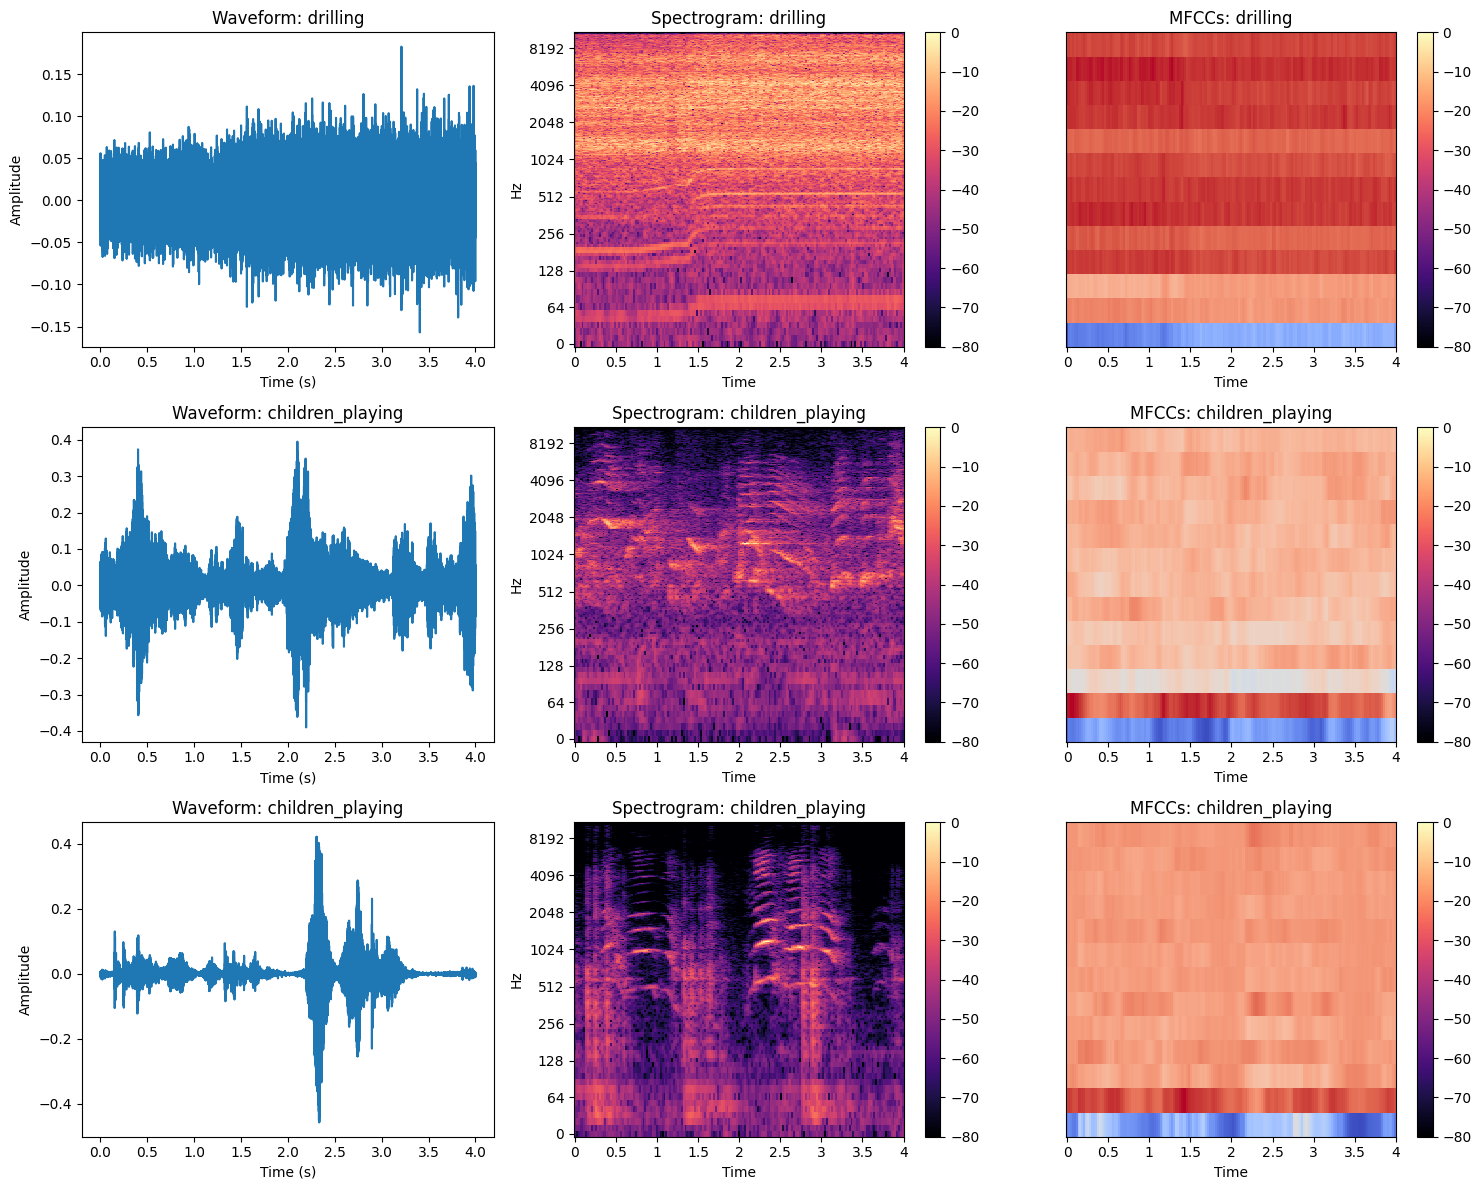

In [6]:
# 5.3 Visualize Sample Audio Files
def plot_sample_audios(metadata, n_samples=3):
    """Plot waveform and spectrogram for sample audio files"""
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 4*n_samples))

    sample_data = metadata.sample(n_samples, random_state=25)

    for idx, (_, row) in enumerate(sample_data.iterrows()):
        file_path = os.path.join(DATASET_PATH, "audio", f"fold{row['fold']}", row['slice_file_name'])

        audio, sr = librosa.load(file_path, sr=22050)

        # Waveform
        axes[idx, 0].plot(np.linspace(0, len(audio)/sr, len(audio)), audio)
        axes[idx, 0].set_title("Waveform: %s" % row['class'])
        axes[idx, 0].set_xlabel('Time (s)')
        axes[idx, 0].set_ylabel('Amplitude')

        # Spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        img = librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr, ax=axes[idx, 1])
        axes[idx, 1].set_title("Spectrogram: %s" % row['class'])
        plt.colorbar(img, ax=axes[idx, 1])

        # MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfccs, x_axis='time', ax=axes[idx, 2])
        axes[idx, 2].set_title("MFCCs: %s" % row['class'])
        plt.colorbar(img, ax=axes[idx, 2])

    plt.tight_layout()
    plt.show()

# Plot sample audio analysis
plot_sample_audios(metadata, n_samples=3)

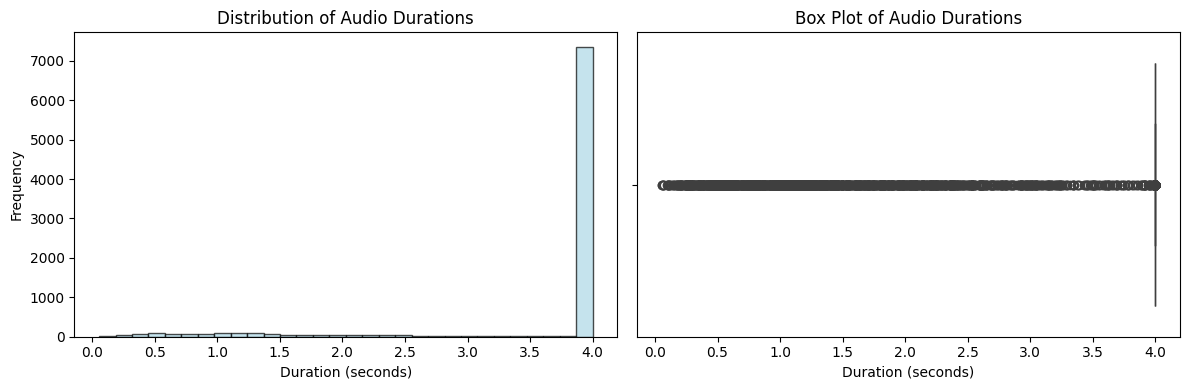

Duration Statistics:
Mean: 3.61s
Std: 0.97s
Min: 0.05s
Max: 4.00s


In [7]:
# 5.4 Duration Analysis
durations = metadata['end'] - metadata['start']
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(durations, bins=30, alpha=.7, color='lightblue', edgecolor='black')
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=durations)
plt.title('Box Plot of Audio Durations')
plt.xlabel('Duration (seconds)')

plt.tight_layout()
plt.show()

print("Duration Statistics:")
print("Mean: %.2fs" % durations.mean())
print("Std: %.2fs" % durations.std())
print("Min: %.2fs" % durations.min())
print("Max: %.2fs" % durations.max())

### 5.4 Observations

As seen above, the data is extremely skewed. The tail to the left, while very weak, should be kept in mind when performing operations on the data, especially feature extraction.

## 6. Data Preprocessing
**Preprocessing Steps**:
1. **Feature Extraction**: MFCC (Mel-Frequency Cepstral Coefficients) with delta and delta-delta features
2. **Feature Aggregation**: Mean, standard deviation, and median across time frames
3. **Feature Scaling**: StandardScaler for normalization
4. **Label Encoding**: Convert class labels to numerical format
5. **Data Splitting**: Predefined folds for training, validation, and testing

Cropping or (random) sampling of waveform data was not performed as the clips are already very short (<= 4s).

Note that feature aggregation was skipped for LSTMs so as to preserve the temporal sequence of the data.

**Benefits of the preprocessing steps**:
- MFCCs are well-established for audio classification as they capture perceptual frequency characteristics
- Delta features capture temporal dynamics of the audio signal
- Statistical aggregation reduces variable-length audio to fixed-length feature vectors
- Standard scaling ensures stable training of neural networks
- Fixed fold assignment ensures reproducible evaluation

In [8]:
# Define fixed folds for model selection
VAL_FOLD = 9
TEST_FOLD = 10
TRAIN_FOLDS = [1, 2, 3, 4, 5, 6, 7, 8]

print("Fold Assignment:")
print("Training folds:", TRAIN_FOLDS)
print("Validation fold:", VAL_FOLD)
print("Test fold:", TEST_FOLD)

Fold Assignment:
Training folds: [1, 2, 3, 4, 5, 6, 7, 8]
Validation fold: 9
Test fold: 10


In [9]:
# Precompute features for all data once
def precompute_all_features(metadata):
    all_features = []
    all_features_sequential = []
    all_labels = []
    all_folds = []

    print("Precomputing features for all audio files...")
    for _, row in metadata.iterrows():
        file_path = os.path.join(DATASET_PATH, "audio", f"fold{row['fold']}", row['slice_file_name'])

        audio, sr = librosa.load(file_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, n_fft=2048, hop_length=512)

        mfccs_delta = librosa.feature.delta(mfccs, mode='nearest')
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2, mode='nearest')

        features_combined = np.vstack([mfccs, mfccs_delta, mfccs_delta2])
        features_aggregated = np.concatenate([
            np.mean(features_combined, axis=1),
            np.std(features_combined, axis=1),
            np.median(features_combined, axis=1)
        ])

        features_sequential = features_combined.T

        all_features.append(features_aggregated)
        all_features_sequential.append(features_sequential)
        all_labels.append(row['class'])
        all_folds.append(row['fold'])

    return np.array(all_features), all_features_sequential, np.array(all_labels), np.array(all_folds)

# Precompute features for entire dataset
all_features, all_features_sequential, all_labels, all_folds = precompute_all_features(metadata)
print("Precomputed features shape:", all_features.shape)

Precomputing features for all audio files...
Precomputed features shape: (8732, 360)


In [10]:
# Split data using precomputed features
train_mask = np.isin(all_folds, TRAIN_FOLDS)
val_mask = all_folds == VAL_FOLD
test_mask = all_folds == TEST_FOLD

X_train, y_train = all_features[train_mask], all_labels[train_mask]
X_val, y_val = all_features[val_mask], all_labels[val_mask]
X_test, y_test = all_features[test_mask], all_labels[test_mask]

# Sequential features for LSTM
X_train_seq = [feature for i, feature in enumerate(all_features_sequential) if train_mask[i]]
X_val_seq = [feature for i, feature in enumerate(all_features_sequential) if val_mask[i]]
X_test_seq = [feature for i, feature in enumerate(all_features_sequential) if test_mask[i]]

print("Training set:", X_train.shape[0], "samples")
print("Validation set:", X_val.shape[0], "samples")
print("Test set:", X_test.shape[0], "samples")

# Verify class distribution
print("\nClass distribution across splits:")
print("\nTraining:", pd.Series(y_train).value_counts().sort_index(), sep='\n')
print("\nValidation:", pd.Series(y_val).value_counts().sort_index(), sep='\n')
print("\nTest:", pd.Series(y_test).value_counts().sort_index(), sep='\n')

Training set: 7079 samples
Validation set: 816 samples
Test set: 837 samples

Class distribution across splits:

Training:
air_conditioner     800
car_horn            364
children_playing    800
dog_bark            800
drilling            800
engine_idling       818
gun_shot            311
jackhammer          822
siren               764
street_music        800
Name: count, dtype: int64

Validation:
air_conditioner     100
car_horn             32
children_playing    100
dog_bark            100
drilling            100
engine_idling        89
gun_shot             31
jackhammer           82
siren                82
street_music        100
Name: count, dtype: int64

Test:
air_conditioner     100
car_horn             33
children_playing    100
dog_bark            100
drilling            100
engine_idling        93
gun_shot             32
jackhammer           96
siren                83
street_music        100
Name: count, dtype: int64


In [11]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print("%s: %d" % (class_name, i))

Class mapping:
air_conditioner: 0
car_horn: 1
children_playing: 2
dog_bark: 3
drilling: 4
engine_idling: 5
gun_shot: 6
jackhammer: 7
siren: 8
street_music: 9


In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Scale sequential features for LSTM and pad to consistent length
all_train_seq = np.vstack(X_train_seq)
scaler_seq = StandardScaler()
scaler_seq.fit(all_train_seq)

X_train_seq_scaled = [scaler_seq.transform(seq) for seq in X_train_seq]
X_val_seq_scaled = [scaler_seq.transform(seq) for seq in X_val_seq]
X_test_seq_scaled = [scaler_seq.transform(seq) for seq in X_test_seq]

# Find max sequence length for padding
max_length = max(len(seq) for seq in X_train_seq_scaled)
print(f"Maximum sequence length: {max_length}")

# Pad all sequences to consistent length
X_train_seq_padded = pad_sequences(X_train_seq_scaled, maxlen=max_length, dtype='float32', padding='post')
X_val_seq_padded = pad_sequences(X_val_seq_scaled, maxlen=max_length, dtype='float32', padding='post')
X_test_seq_padded = pad_sequences(X_test_seq_scaled, maxlen=max_length, dtype='float32', padding='post')

print("Padded training sequences shape:", X_train_seq_padded.shape)
print("Padded validation sequences shape:", X_val_seq_padded.shape)
print("Padded test sequences shape:", X_test_seq_padded.shape)

# Reshape for CNN/MLP models
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

Maximum sequence length: 174
Padded training sequences shape: (7079, 174, 120)
Padded validation sequences shape: (816, 174, 120)
Padded test sequences shape: (837, 174, 120)


## 7. Model Selection and Architecture

### Choice of Models:

1. **MLP (Multi-Layer Perceptron)**: Baseline model for comparison, good for structured feature data
2. **CNN (Convolutional Neural Network)**: Effective for capturing local patterns in feature sequences
3. **LSTM (Long Short-Term Memory)**: Suitable for sequenced structure of audio data

The models (especially CNN and LSTM) are complex and therefore very time consuming. However, especially for MLP and CNN, they can be greatly accelerated by GPU so training feels almost instant, as long as the model is not too big to store in the GPU's memory. LSTM does take longer, but it remains tolerable.

Instead of designing fixed rigid structures for the models, the structure is made configurable such that it is easily modified by the hyperpameter tuning function (including the number of layers and units in each layer).

In terms of feasibility, LSTM is ts the top contender. LSTM (and RNNs in general) were designed with sequential data in mind.

### Optimization Methods and Training Strategies

- **Hyperparameter Tuning with Bayesian Optimization**: KerasTuner is used with Bayesian Optimization. This is more efficient than random/grid search for high-dimensional hyperparameter spaces. It works by building a probabilistic model of the objective function to guide the search toward promising regions, which helps find better configurations with fewer trials compared to random search. It is given a function which takes a hyperparameter object and returns a trainable object, thus fully automating the process.
- **Learning Rate Scheduling**: ReduceLROnPlateau from Keras is used, which is provided as a callback. This prevents overshooting and helps converge to a better minima. Larger initial steps can now be taken for fast progress, while fine-tuning proceeds later with smaller steps.
- **Early Stopping**: This too is provided by Keras as a callback. It detects overfitting and reverts the model to the best performing epoch. This reduces the need to tune the training duration and saves time.
- **Batch Normalization**: It stabilizes and accelerates training by normalizing the layer inputs, allowing higher learning rates while keeping the inputs of each layer stable and within acceptable range.
- **Dropout Regularization**: It prevents overfitting in large networks by randomly dropping units during training. This makes co-adaptation, and thus overfitting, less likely.

During training and hyperparameter tuning, the validation fold is used to evaluate the performance of the model and whether it has overfit. But when choosing the best model, the separate test fold is used instead, as the early stopping used during the hyperparameter tuning and subsequent training might have led to a data leak from the validation dataset.

In [13]:
def build_mlp_model(hp):
    """Build MLP model with tunable hyperparameters"""
    input_dim = X_train_scaled.shape[1]
    num_classes = len(label_encoder.classes_)

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for i in range(hp.Int('num_layers', 2, 5)):
        units = hp.Int(f'units_{i}', min_value=128, max_value=512, step=128)
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', .2, .6)))

    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model(hp):
    """Build CNN model with tunable hyperparameters"""
    input_dim = X_train_scaled.shape[1]
    num_classes = len(label_encoder.classes_)

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model = keras.Sequential()
    model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

    for i in range(hp.Int('conv_layers', 2, 4)):
        filters = hp.Int(f'filters_{i}', min_value=32, max_value=256, step=32)
        kernel_size = hp.Int(f'kernel_{i}', min_value=3, max_value=7, step=2)
        model.add(layers.Conv1D(filters, kernel_size, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(2))

    model.add(layers.GlobalAveragePooling1D())

    for i in range(hp.Int('dense_layers', 1, 3)):
        units = hp.Int(f'dense_units_{i}', min_value=64, max_value=256, step=64)
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float('dense_dropout', .3, .6)))

    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model(hp):
    """Build LSTM model with tunable hyperparameters"""
    num_classes = len(label_encoder.classes_)

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model = keras.Sequential()
    # Use fixed input shape now that we have padded sequences
    model.add(layers.Input(shape=(X_train_seq_padded.shape[1], X_train_seq_padded.shape[2])))

    # Always return sequences and use GlobalAveragePooling1D at the end
    for i in range(hp.Int('lstm_layers', 1, 3)):
        units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=192, step=32)
        model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float(f'lstm_dropout_{i}', .2, .5)))

    # Always use GlobalAveragePooling1D to reduce from 3D to 2D
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def run_model_specific_tuning(model_type, max_trials=15):
    """Run hyperparameter tuning for a specific model type"""

    if model_type == 'mlp':
        X_train_tune, X_val_tune = X_train_reshaped, X_val_reshaped
        build_func = build_mlp_model
    elif model_type == 'cnn':
        X_train_tune, X_val_tune = X_train_reshaped, X_val_reshaped
        build_func = build_cnn_model
    elif model_type == 'lstm':
        X_train_tune, X_val_tune = X_train_seq_padded, X_val_seq_padded
        build_func = build_lstm_model

    tuner = kt.BayesianOptimization(
        build_func,
        objective='val_accuracy',
        max_trials=max_trials,
        directory='model_tuning',
        project_name='urban_sound_'+model_type,
        overwrite=True
    )

    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, min_lr=1e-7)
    ]

    tuner.search(
        X_train_tune, y_train_encoded,
        epochs=50,
        validation_data=(X_val_tune, y_val_encoded),
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    return { 'model': best_model, 'hyperparameters': best_hps, 'tuner': tuner, 'val_acc': best_model.evaluate(X_val_tune, y_val_encoded, verbose=0)[1] }

In [15]:
# Run separate hyperparameter tuning for each model type
tuning_results = {
    model_type: run_model_specific_tuning(model_type, max_trials=30) for model_type in ('lstm', 'mlp', 'cnn', )
}

Trial 30 Complete [00h 00m 57s]
val_accuracy: 0.655637264251709

Best val_accuracy So Far: 0.7340686321258545
Total elapsed time: 00h 26m 00s


In [16]:
for model_type, results in tuning_results.items():
    print("\nBest %s hyperparameters:" % model_type.upper())
    print("="*50)
    for param_value_pair in results["hyperparameters"].values.items():
        print("%s: %s" % param_value_pair)
    print("Best %s validation accuracy: %.4f" % (model_type.upper(), results["val_acc"]))


Best LSTM hyperparameters:
learning_rate: 0.0020892318343141343
lstm_layers: 3
lstm_units_0: 128
lstm_dropout_0: 0.3014584809870033
optimizer: adam
lstm_units_1: 192
lstm_dropout_1: 0.37894010168721504
lstm_units_2: 192
lstm_dropout_2: 0.4539190115669239
Best LSTM validation accuracy: 0.7721

Best MLP hyperparameters:
learning_rate: 0.0006414389487374852
num_layers: 3
units_0: 128
dropout_0: 0.2549379815237772
units_1: 256
dropout_1: 0.296638711452595
optimizer: rmsprop
units_2: 512
dropout_2: 0.23229931195557138
units_3: 512
dropout_3: 0.5592338696890691
units_4: 512
dropout_4: 0.24807827859902126
Best MLP validation accuracy: 0.7341

Best CNN hyperparameters:
learning_rate: 0.00169020528847342
conv_layers: 3
filters_0: 128
kernel_0: 5
filters_1: 192
kernel_1: 5
dense_layers: 2
dense_units_0: 256
dense_dropout: 0.5375948485374548
optimizer: rmsprop
filters_2: 128
kernel_2: 7
dense_units_1: 64
dense_units_2: 256
filters_3: 96
kernel_3: 7
Best CNN validation accuracy: 0.7341


## 8. Results and Analysis

From the hyperparameter tuning results above, we see that the LSTM model is a clear winner. However, the three models will be retrained so that we have access to their training histories, and then they will be compared using the test fold (instead of the validation fold used till now).

Test-accuracy will be the main metric. In addition, precision, recall, and f1-score will be calculated along with the display of a correlation matrix.

In [17]:
# Train and compare the best models from each architecture type
model_histories = {}
trained_models = {}

for model_type, results in tuning_results.items():
    print("\n--- Training Best %s Model ---" % model_type.upper())

    # Assign the appropriate model and data
    if model_type == 'mlp':
        train_data, val_data = X_train_reshaped, X_val_reshaped
        model = build_mlp_model(results["hyperparameters"])
    elif model_type == 'cnn':
        train_data, val_data = X_train_reshaped, X_val_reshaped
        model = build_cnn_model(results["hyperparameters"])
    elif model_type == 'lstm':
        train_data, val_data = X_train_seq_padded, X_val_seq_padded
        model = build_lstm_model(results["hyperparameters"])

    # Training again to obtain history
    history = model.fit(
        train_data, y_train_encoded,
        validation_data=(val_data, y_val_encoded),
        epochs=80,
        batch_size=32,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(patience=6, factor=.5, min_lr=1e-7)
        ],
        verbose=1
    )

    # Store the trained model and history
    trained_models[model_type] = model
    model_histories[model_type] = history

    # Evaluate on validation set
    val_accuracy = model.evaluate(val_data, y_val_encoded, verbose=0)[1]
    print("Best %s validation accuracy: %.4f" % (model_type.upper(), val_accuracy))


--- Training Best LSTM Model ---
Epoch 1/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.7654 - loss: 0.7439 - val_accuracy: 0.6042 - val_loss: 1.5732 - learning_rate: 0.0021
Epoch 2/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9182 - loss: 0.2542 - val_accuracy: 0.6949 - val_loss: 1.6391 - learning_rate: 0.0021
Epoch 3/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9510 - loss: 0.1495 - val_accuracy: 0.6924 - val_loss: 1.9613 - learning_rate: 0.0021
Epoch 4/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9648 - loss: 0.1155 - val_accuracy: 0.7022 - val_loss: 2.0459 - learning_rate: 0.0021
Epoch 5/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.9684 - loss: 0.1014 - val_accuracy: 0.7525 - val_loss: 1.8465 - learning_rate: 0.0021
Epoch 6/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9790 - loss: 0.0655 - val_accuracy: 0.7267 - val_loss: 1.9839 - learning_rate: 0.0021
Epoch 7/80
222/222 ━━━━━━━━━━━━━━━━━━━━ 21

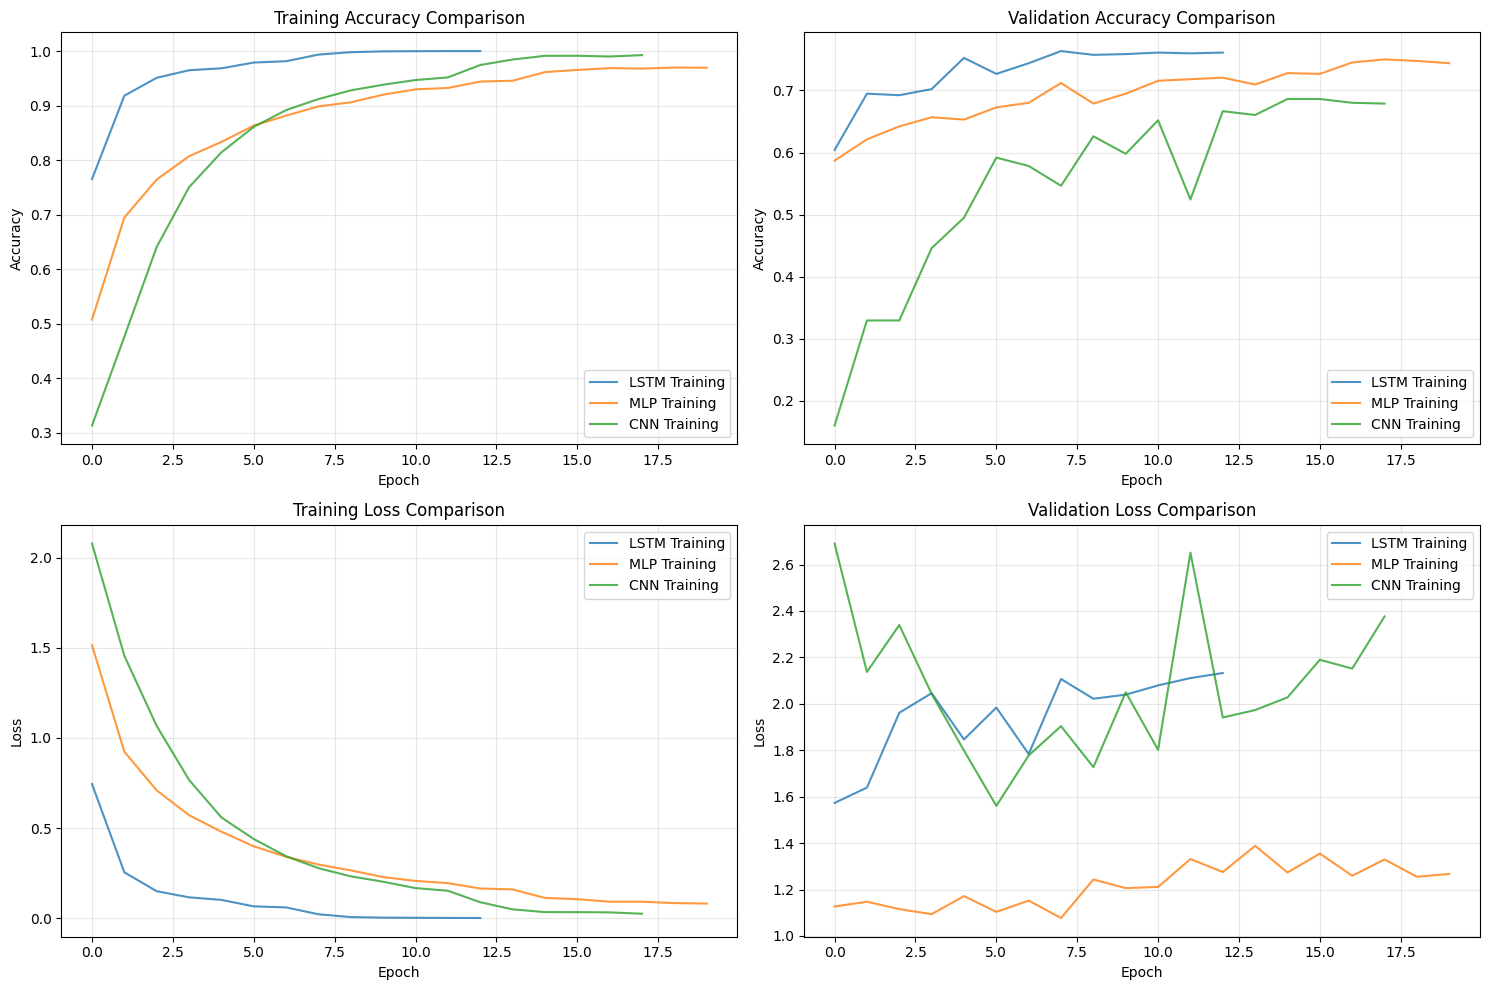

In [18]:
# Compare training histories across model types
plt.figure(figsize=(15, 10))

# Plot training accuracy
plt.subplot(2, 2, 1)
for model_type, history in model_histories.items():
    plt.plot(history.history['accuracy'], label=model_type.upper()+' Training', alpha=.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=.3)

# Plot validation accuracy
plt.subplot(2, 2, 2)
for model_type, history in model_histories.items():
    plt.plot(history.history['val_accuracy'], label=model_type.upper()+' Training', alpha=.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=.3)

# Plot training loss
plt.subplot(2, 2, 3)
for model_type, history in model_histories.items():
    plt.plot(history.history['loss'], label=model_type.upper()+' Training', alpha=.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=.3)

# Plot validation loss
plt.subplot(2, 2, 4)
for model_type, history in model_histories.items():
    plt.plot(history.history['val_loss'], label=model_type.upper()+' Training', alpha=.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=.3)

plt.tight_layout()
plt.show()

In [19]:
# Final evaluation on test set for all best model types
print("=== FINAL EVALUATION ON TEST SET (FOLD 10) - ALL MODEL TYPES ===")

test_results = {}

for model_type, model in trained_models.items():
    print("\n--- Evaluating Best %s Model ---" % model_type.upper())

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test_seq_padded if model_type=="lstm" else X_test_reshaped, y_test_encoded, verbose=0)
    y_pred = model.predict(X_test_seq_padded if model_type=="lstm" else X_test_reshaped, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Store results
    test_results[model_type] = {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'y_pred': y_pred,
        'y_pred_classes': y_pred_classes
    }

    print("Test Accuracy: %.4f" % test_accuracy)
    print("Test Loss: %.4f" % test_loss)

    # Classification report
    print("\nClassification Report for %s:" % model_type.upper())
    print(classification_report(y_test_encoded, y_pred_classes,
                              target_names=label_encoder.classes_))

=== FINAL EVALUATION ON TEST SET (FOLD 10) - ALL MODEL TYPES ===

--- Evaluating Best LSTM Model ---
Test Accuracy: 0.6320
Test Loss: 1.3212

Classification Report for LSTM:
                  precision    recall  f1-score   support

 air_conditioner       0.65      0.39      0.49       100
        car_horn       0.67      0.85      0.75        33
children_playing       0.70      0.78      0.74       100
        dog_bark       0.67      0.76      0.71       100
        drilling       0.50      0.54      0.52       100
   engine_idling       0.66      0.78      0.72        93
        gun_shot       0.66      0.84      0.74        32
      jackhammer       0.44      0.50      0.47        96
           siren       0.64      0.57      0.60        83
    street_music       0.86      0.59      0.70       100

        accuracy                           0.63       837
       macro avg       0.64      0.66      0.64       837
    weighted avg       0.64      0.63      0.63       837


--- Evalua

2025-10-02 16:56:09.381543: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng12{k11=2} for conv (f32[5,128,1,90]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,192,1,90]{3,2,1,0}, f32[128,192,1,7]{3,2,1,0}, f32[128]{0}), window={size=1x7 pad=0_0x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-10-02 16:56:09.532982: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.145394014s
Trying algorithm eng12{k11=2} for conv (f32[5,128,1,90]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,192,1,90]{3,2,1,0}, f32[128,192,1,7]{3,2,1,0}, f32[128]{0}), window={size=1x7 pad=0_0x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

Test Accuracy: 0.6332
Test Loss: 1.1957

Classification Report for CNN:
                  precision    recall  f1-score   support

 air_conditioner       0.55      0.75      0.63       100
        car_horn       0.69      0.76      0.72        33
children_playing       0.63      0.77      0.69       100
        dog_bark       0.92      0.44      0.59       100
        drilling       0.60      0.27      0.37       100
   engine_idling       0.52      0.69      0.59        93
        gun_shot       0.67      0.88      0.76        32
      jackhammer       0.61      0.97      0.75        96
           siren       0.73      0.58      0.64        83
    street_music       0.78      0.49      0.60       100

        accuracy                           0.63       837
       macro avg       0.67      0.66      0.64       837
    weighted avg       0.67      0.63      0.62       837



In [20]:
# Comparative performance analysis
comparison_data = []
for model_type, results in test_results.items():
    # Calculate additional metrics
    cm = confusion_matrix(y_test_encoded, results['y_pred_classes'])
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)

    comparison_data.append({
        'Model Type': model_type.upper(),
        'Test Accuracy': results['test_accuracy'],
        'Test Loss': results['test_loss'],
        'Mean Precision': np.nanmean(precision),
        'Mean Recall': np.nanmean(recall),
        'Mean F1-Score': np.nanmean(f1),
        'Hyperparameter Score': tuning_results[model_type]['val_acc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("Performance Comparison Across Model Types:")
display(comparison_df)

Performance Comparison Across Model Types:


,Model Type,Test Accuracy,Test Loss,Mean Precision,Mean Recall,Mean F1-Score,Hyperparameter Score
1,MLP,0.682198,1.153798,0.722072,0.701341,0.703705,0.734069
2,CNN,0.633214,1.195693,0.668026,0.658781,0.635427,0.734069
0,LSTM,0.632019,1.321172,0.644468,0.660345,0.643053,0.772059


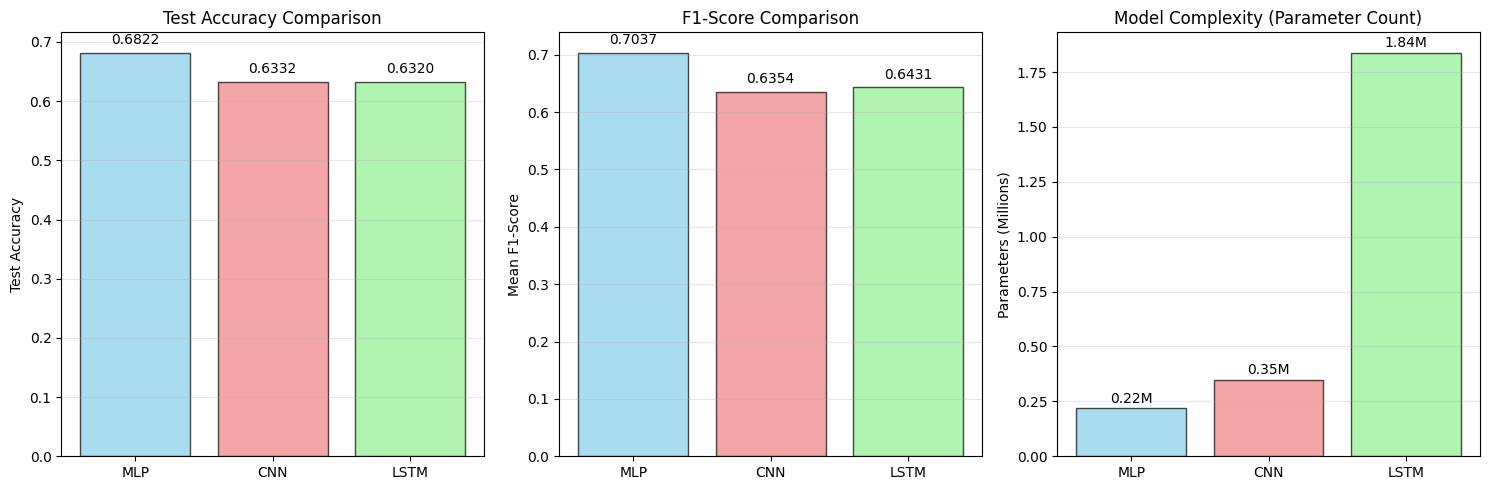

In [21]:
# Visual comparison of model performances
plt.figure(figsize=(15, 5))

# Test accuracy comparison
plt.subplot(1, 3, 1)
model_types = comparison_df['Model Type']
test_accuracies = comparison_df['Test Accuracy']
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = plt.bar(model_types, test_accuracies, color=colors, alpha=.7, edgecolor='black')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, accuracy in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + .01, '%.4f' % accuracy, ha='center', va='bottom')

# F1-score comparison
plt.subplot(1, 3, 2)
f1_scores = comparison_df['Mean F1-Score']
bars = plt.bar(model_types, f1_scores, color=colors, alpha=.7, edgecolor='black')
plt.ylabel('Mean F1-Score')
plt.title('F1-Score Comparison')
plt.grid(True, alpha=.3, axis='y')

for bar, f1_score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + .01, '%.4f' % f1_score, ha='center', va='bottom')

# Training time and complexity analysis (approximate)
plt.subplot(1, 3, 3)
# Count parameters as proxy for model complexity
param_counts = {}
for model_type, model in trained_models.items():
    param_counts[model_type] = model.count_params() / 1e6  # In millions

param_values = [param_counts.get(mt.lower(), 0) for mt in model_types]
bars = plt.bar(model_types, param_values, color=colors, alpha=.7, edgecolor='black')
plt.ylabel('Parameters (Millions)')
plt.title('Model Complexity (Parameter Count)')
plt.grid(True, alpha=0.3, axis='y')

for bar, params in zip(bars, param_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, '%.2fM' % params, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [22]:
# Select the best overall model based on test performance
best_overall_type = comparison_df.iloc[0]['Model Type'].lower()
best_overall_model = trained_models[best_overall_type]
best_overall_results = test_results[best_overall_type]

print("\nBest overall model:", best_overall_type.upper())
print("Test Accuracy: %.4f" % best_overall_results['test_accuracy'])

# Update the final_model variable to use the best overall model
final_model = best_overall_model
final_history = model_histories[best_overall_type]

# Get the best configuration from tuning results
best_hps = tuning_results[best_overall_type]['hyperparameters']


Best overall model: MLP
Test Accuracy: 0.6822


In [23]:
# 10-Fold Cross-Validation with Detailed Metrics and Confusion Matrix
def run_comprehensive_cross_validation(all_features, all_features_sequential, all_labels, all_folds, best_hps, n_folds=10):
    """Comprehensive cross-validation with confusion matrix aggregation"""

    fold_accuracies = []
    all_true_labels = []
    all_predicted_labels = []
    label_encoder_cv = LabelEncoder()
    labels_encoded = label_encoder_cv.fit_transform(all_labels)

    for test_fold in range(1, n_folds + 1):
        print("\n--- Fold %d/%d ---" % (test_fold, n_folds))

        # Use current fold for testing, previous fold for validation
        val_fold = test_fold - 1 if test_fold > 1 else n_folds
        train_folds = [f for f in range(1, n_folds + 1) if f not in [test_fold, val_fold]]

        # Get indices using precomputed features
        train_mask = np.isin(all_folds, train_folds)
        val_mask = all_folds == val_fold
        test_mask = all_folds == test_fold

        # For MLP/CNN (aggregated features)
        y_train_fold = labels_encoded[train_mask]
        y_val_fold = labels_encoded[val_mask]
        y_test_fold = labels_encoded[test_mask]

        # Rebuild and train model for this fold
        if best_overall_type == 'lstm':
            model_fold = build_lstm_model(best_hps)

            # For LSTM (sequential features)
            X_train_seq_fold = [feature for feature, mask in zip(all_features_sequential, train_mask) if mask]
            X_val_seq_fold = [feature for feature, mask in zip(all_features_sequential, val_mask) if mask]
            X_test_seq_fold = [feature for feature, mask in zip(all_features_sequential, test_mask) if mask]

            # Scale and pad sequential features for LSTM
            all_train_seq_fold = np.vstack(X_train_seq_fold)
            scaler_seq_fold = StandardScaler()
            scaler_seq_fold.fit(all_train_seq_fold)

            X_train_seq_scaled_fold = [scaler_seq_fold.transform(seq) for seq in X_train_seq_fold]
            X_val_seq_scaled_fold = [scaler_seq_fold.transform(seq) for seq in X_val_seq_fold]
            X_test_seq_scaled_fold = [scaler_seq_fold.transform(seq) for seq in X_test_seq_fold]

            # Pad sequences to consistent length
            max_length_fold = max(len(seq) for seq in X_train_seq_scaled_fold)
            X_train_seq_padded_fold = pad_sequences(X_train_seq_scaled_fold, maxlen=max_length_fold, dtype='float32', padding='post')
            X_val_seq_padded_fold = pad_sequences(X_val_seq_scaled_fold, maxlen=max_length_fold, dtype='float32', padding='post')
            X_test_seq_padded_fold = pad_sequences(X_test_seq_scaled_fold, maxlen=max_length_fold, dtype='float32', padding='post')

            train_data, val_data, test_data = X_train_seq_padded_fold, X_val_seq_padded_fold, X_test_seq_padded_fold
        else:
            # For MLP/CNN (aggregated features)
            X_train_fold = all_features[train_mask]
            X_val_fold = all_features[val_mask]
            X_test_fold = all_features[test_mask]

            # Scale features per fold
            scaler_fold = StandardScaler()
            X_train_scaled_fold = scaler_fold.fit_transform(X_train_fold)
            X_val_scaled_fold = scaler_fold.transform(X_val_fold)
            X_test_scaled_fold = scaler_fold.transform(X_test_fold)

            # Reshape for CNN/MLP
            X_train_reshaped_fold = X_train_scaled_fold.reshape(X_train_scaled_fold.shape[0], X_train_scaled_fold.shape[1], 1)
            X_val_reshaped_fold = X_val_scaled_fold.reshape(X_val_scaled_fold.shape[0], X_val_scaled_fold.shape[1], 1)
            X_test_reshaped_fold = X_test_scaled_fold.reshape(X_test_scaled_fold.shape[0], X_test_scaled_fold.shape[1], 1)

            train_data, val_data, test_data = X_train_reshaped_fold, X_val_reshaped_fold, X_test_reshaped_fold
            if best_overall_type == 'mlp':
                model_fold = build_mlp_model(best_hps)
            elif best_overall_type == 'cnn':
                model_fold = build_cnn_model(best_hps)

        model_fold.compile(
            optimizer=keras.optimizers.Adam(learning_rate=best_hps['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        history_fold = model_fold.fit(
            train_data, y_train_fold,
            validation_data=(val_data, y_val_fold),
            epochs=80,
            batch_size=32,
            verbose=0,
            callbacks=[
                keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
            ]
        )

        # Evaluate on test fold
        test_accuracy_fold = model_fold.evaluate(test_data, y_test_fold, verbose=0)[1]
        fold_accuracies.append(test_accuracy_fold)

        # Get predictions for confusion matrix
        y_pred_fold = model_fold.predict(test_data, verbose=0)
        y_pred_classes_fold = np.argmax(y_pred_fold, axis=1)

        # Store true and predicted labels for overall confusion matrix
        all_true_labels.extend(y_test_fold)
        all_predicted_labels.extend(y_pred_classes_fold)

        print("Fold %d Test Accuracy: %.4f" % (test_fold, test_accuracy_fold))
        print("Fold %d Samples: %d" % (test_fold, len(y_test_fold)))

        # Clean up
        del model_fold
        tf.keras.backend.clear_session()

    return fold_accuracies, all_true_labels, all_predicted_labels

# Run comprehensive cross-validation
cv_accuracies, cv_true_labels, cv_predicted_labels = run_comprehensive_cross_validation(
    all_features, all_features_sequential, all_labels, all_folds, best_hps
)


--- Fold 1/10 ---
Fold 1 Test Accuracy: 0.6323
Fold 1 Samples: 873

--- Fold 2/10 ---
Fold 2 Test Accuracy: 0.5653
Fold 2 Samples: 888

--- Fold 3/10 ---
Fold 3 Test Accuracy: 0.6205
Fold 3 Samples: 925

--- Fold 4/10 ---
Fold 4 Test Accuracy: 0.6172
Fold 4 Samples: 990

--- Fold 5/10 ---
Fold 5 Test Accuracy: 0.6004
Fold 5 Samples: 936

--- Fold 6/10 ---
Fold 6 Test Accuracy: 0.6039
Fold 6 Samples: 823

--- Fold 7/10 ---
Fold 7 Test Accuracy: 0.5800
Fold 7 Samples: 838

--- Fold 8/10 ---
Fold 8 Test Accuracy: 0.6253
Fold 8 Samples: 806

--- Fold 9/10 ---
Fold 9 Test Accuracy: 0.6213
Fold 9 Samples: 816

--- Fold 10/10 ---
Fold 10 Test Accuracy: 0.6153
Fold 10 Samples: 837


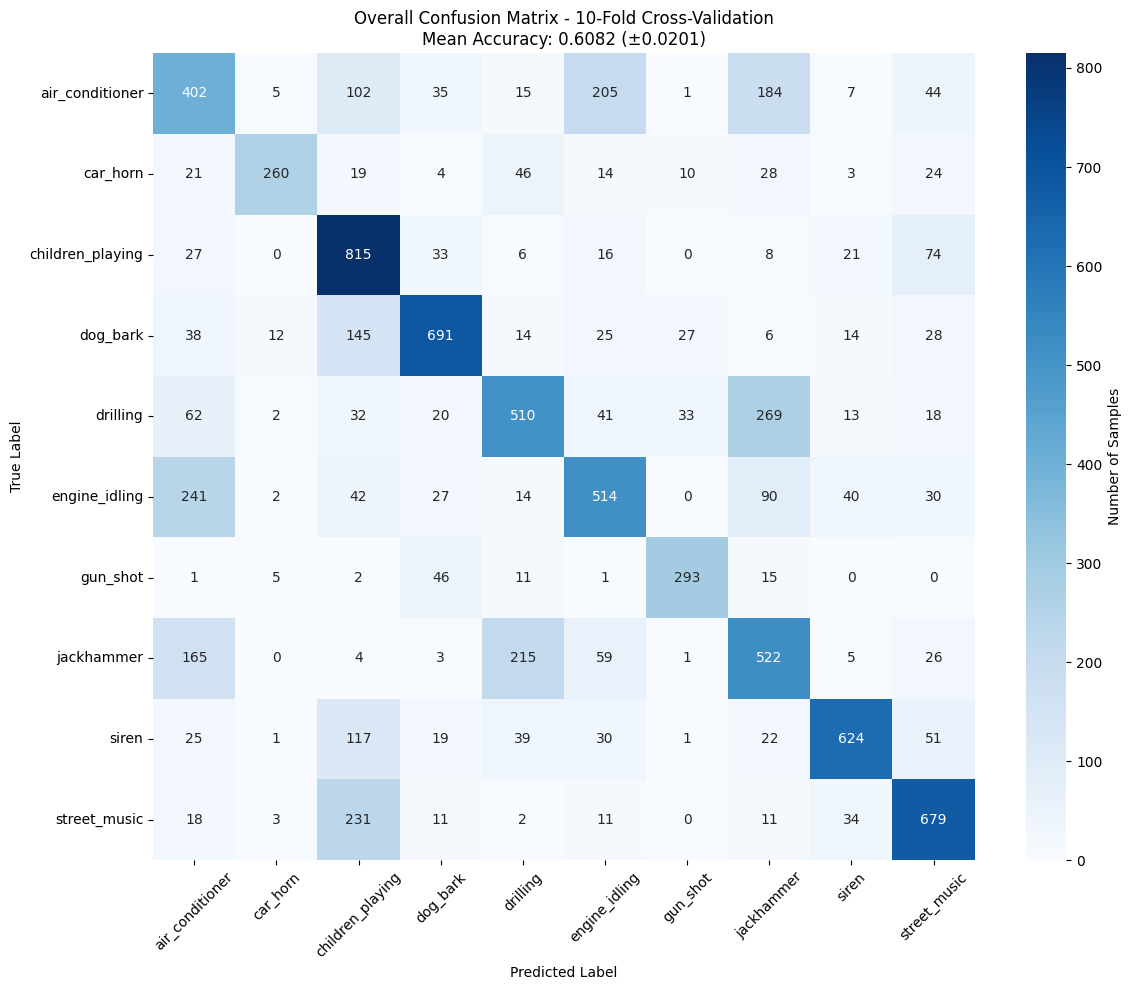

In [24]:
# Create overall confusion matrix for 10-fold cross-validation

# Convert back to original class names
cv_true_labels_names = label_encoder.inverse_transform(cv_true_labels)
cv_predicted_labels_names = label_encoder.inverse_transform(cv_predicted_labels)

# Create the overall confusion matrix
cv_cm = confusion_matrix(cv_true_labels_names, cv_predicted_labels_names, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cv_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Number of Samples'})
plt.title('Overall Confusion Matrix - 10-Fold Cross-Validation\nMean Accuracy: %.4f (±%.4f)' % (np.mean(cv_accuracies), np.std(cv_accuracies)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

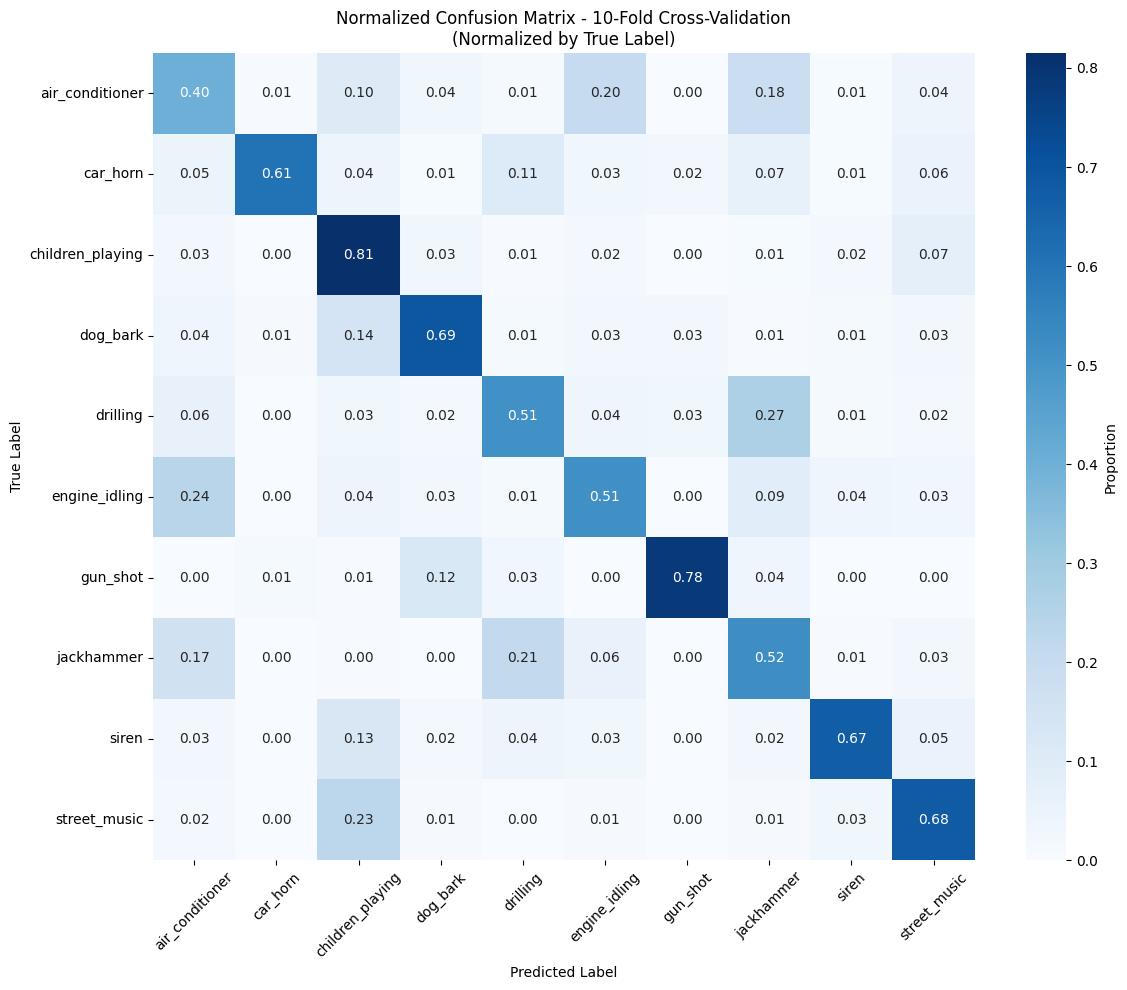

In [25]:
# Normalized confusion matrix (by true labels)
cv_cm_normalized = cv_cm.astype('float') / cv_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cv_cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix - 10-Fold Cross-Validation\n'
          '(Normalized by True Label)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
# Per-class performance analysis from cross-validation
cv_class_report = classification_report(cv_true_labels_names, cv_predicted_labels_names, target_names=label_encoder.classes_, output_dict=True)
cv_class_report_df = pd.DataFrame(cv_class_report).transpose()

print("Classification Report (10-Fold CV):")
print(classification_report(cv_true_labels_names, cv_predicted_labels_names, target_names=label_encoder.classes_))

Classification Report (10-Fold CV):
                  precision    recall  f1-score   support

 air_conditioner       0.40      0.40      0.40      1000
        car_horn       0.90      0.61      0.72       429
children_playing       0.54      0.81      0.65      1000
        dog_bark       0.78      0.69      0.73      1000
        drilling       0.58      0.51      0.54      1000
   engine_idling       0.56      0.51      0.54      1000
        gun_shot       0.80      0.78      0.79       374
      jackhammer       0.45      0.52      0.48      1000
           siren       0.82      0.67      0.74       929
    street_music       0.70      0.68      0.69      1000

        accuracy                           0.61      8732
       macro avg       0.65      0.62      0.63      8732
    weighted avg       0.63      0.61      0.61      8732



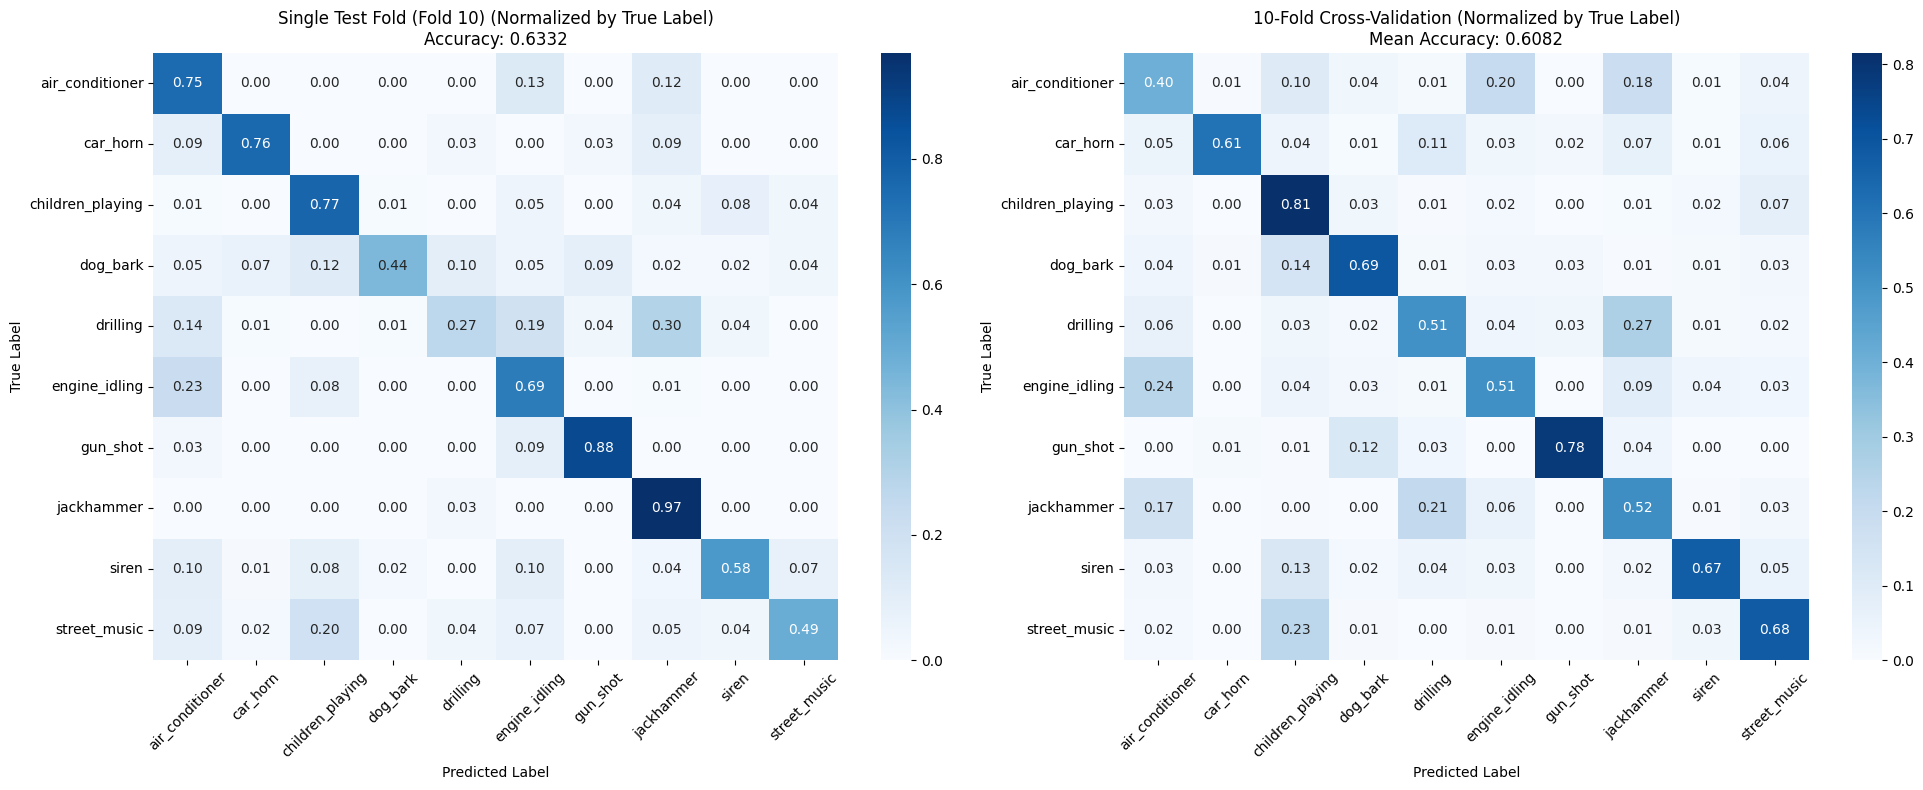

In [27]:
# Compare single test fold vs cross-validation performance

# Single fold confusion matrix (from previous evaluation)
single_cm = confusion_matrix(y_test_encoded, y_pred_classes)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Single fold confusion matrix
single_cm_normalized = single_cm.astype('float') / single_cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(single_cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[0], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title('Single Test Fold (Fold 10) (Normalized by True Label)\nAccuracy: %.4f' % test_accuracy)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Cross-validation confusion matrix
sns.heatmap(cv_cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set_title('10-Fold Cross-Validation (Normalized by True Label)\nMean Accuracy: %.4f' % np.mean(cv_accuracies))
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

In [28]:
# Detailed analysis of cross-validation results

# Calculate per-class accuracy from confusion matrix
class_accuracies = np.diag(cv_cm) / np.sum(cv_cm, axis=1)

# Create detailed performance summary
cv_performance_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Samples': np.sum(cv_cm, axis=1),
    'Correct_Predictions': np.diag(cv_cm),
    'Class_Accuracy': class_accuracies,
    'Precision': cv_class_report_df.loc[label_encoder.classes_, 'precision'].values,
    'Recall': cv_class_report_df.loc[label_encoder.classes_, 'recall'].values,
    'F1_Score': cv_class_report_df.loc[label_encoder.classes_, 'f1-score'].values
})

print("\nPer-Class Performance (10-Fold Cross-Validation):")
display(cv_performance_df)

# Identify best and worst performing classes
best_classes = cv_performance_df.nlargest(3, 'Class_Accuracy')
worst_classes = cv_performance_df.nsmallest(3, 'Class_Accuracy')

print("\nBest Performing Classes:")
for _, row in best_classes.iterrows():
    print("\t%s: %.4f" % (row['Class'], row['Class_Accuracy']))

print("\nMost Challenging Classes:")
for _, row in worst_classes.iterrows():
    print("\t%s: %.4f" % (row['Class'], row['Class_Accuracy']))


Per-Class Performance (10-Fold Cross-Validation):


,Class,Samples,Correct_Predictions,Class_Accuracy,Precision,Recall,F1_Score
0,air_conditioner,1000,402,0.402000,0.402000,0.402000,0.402000
1,car_horn,429,260,0.606061,0.896552,0.606061,0.723227
2,children_playing,1000,815,0.815000,0.540093,0.815000,0.649661
3,dog_bark,1000,691,0.691000,0.777278,0.691000,0.731604
4,drilling,1000,510,0.510000,0.584862,0.510000,0.544872
5,engine_idling,1000,514,0.514000,0.561135,0.514000,0.536534
6,gun_shot,374,293,0.783422,0.800546,0.783422,0.791892
7,jackhammer,1000,522,0.522000,0.451948,0.522000,0.484455
8,siren,929,624,0.671690,0.819974,0.671690,0.738462
9,street_music,1000,679,0.679000,0.697125,0.679000,0.687943



Best Performing Classes:
	children_playing: 0.8150
	gun_shot: 0.7834
	dog_bark: 0.6910

Most Challenging Classes:
	air_conditioner: 0.4020
	drilling: 0.5100
	engine_idling: 0.5140


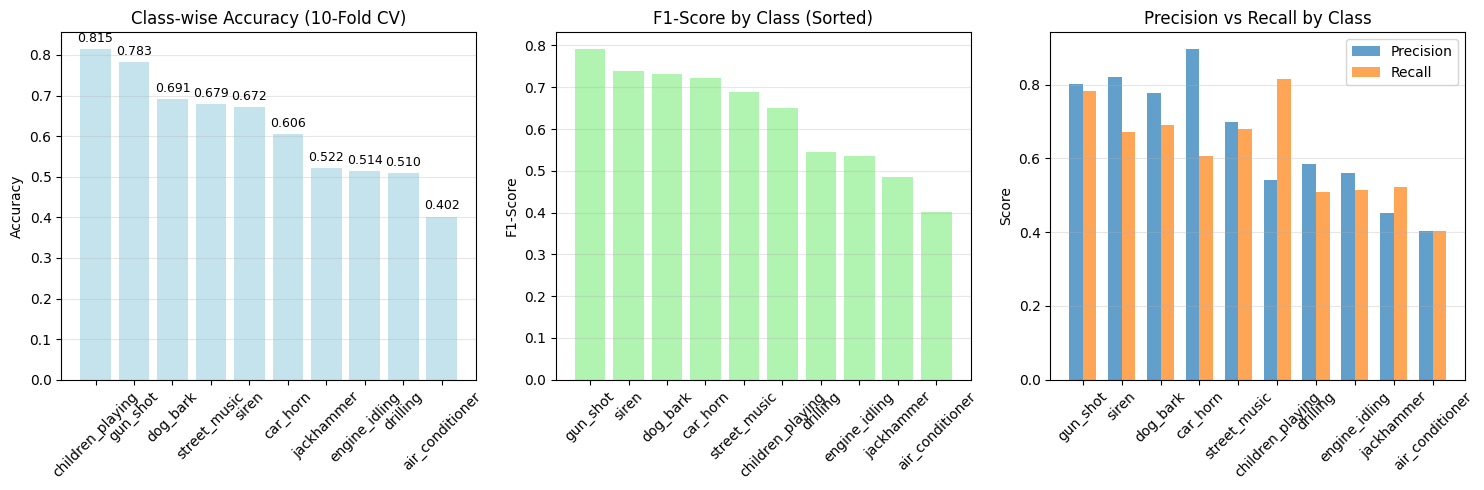

In [29]:
# Visualize class-wise performance
plt.figure(figsize=(15, 5))
x = range(len(label_encoder.classes_))

# Class accuracy comparison
plt.subplot(1, 3, 1)
sorted_indices = np.argsort(class_accuracies)[::-1]
sorted_classes = [label_encoder.classes_[i] for i in sorted_indices]
sorted_accuracies = class_accuracies[sorted_indices]

bars = plt.bar(x, sorted_accuracies, color='lightblue', alpha=.7)
plt.xticks(x, sorted_classes, rotation=45)
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy (10-Fold CV)')
plt.grid(True, alpha=.3, axis='y')

# Add value labels
for bar, acc in zip(bars, sorted_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + .01, '%.3f' % acc, ha='center', va='bottom', fontsize=9)

# F1-Score distribution
plt.subplot(1, 3, 2)
cv_performance_df_f1_scored = cv_performance_df.sort_values('F1_Score', ascending=False)
plt.bar(x, cv_performance_df_f1_scored['F1_Score'], color='lightgreen', alpha=.7)
plt.xticks(x, cv_performance_df_f1_scored['Class'], rotation=45)
plt.ylabel('F1-Score')
plt.title('F1-Score by Class (Sorted)')
plt.grid(True, alpha=.3, axis='y')

# Precision-Recall comparison
plt.subplot(1, 3, 3)
width = .35
plt.bar([i - width/2 for i in x], cv_performance_df_f1_scored['Precision'], width, label='Precision', alpha=.7)
plt.bar([i + width/2 for i in x], cv_performance_df_f1_scored['Recall'], width, label='Recall', alpha=.7)
plt.xticks(x, cv_performance_df_f1_scored['Class'], rotation=45)
plt.ylabel('Score')
plt.title('Precision vs Recall by Class')
plt.legend()
plt.grid(True, alpha=.3, axis='y')

plt.tight_layout()
plt.show()

In [30]:
# Hyperparameter Tuning Analysis
print("Best Model Type:", best_overall_type)
print("Best Model Configuration:")
for param_value in best_hps.values.items():
    print("\t%s: %s" % param_value)

# Visualize hyperparameter search results
tuner_data = []
for model_type, results in tuning_results.items():
    top_trials = results["tuner"].oracle.get_best_trials(num_trials=3)
    for trial in top_trials:
        tuner_data.append({'model_type': model_type, 'score': trial.score, **trial.hyperparameters.values})

tuner_df = pd.DataFrame(tuner_data)
print("\nTop 3 Hyperparameter Configurations from each model type:")
display(tuner_df.sort_values('score', ascending=False).head(10))

Best Model Type: mlp
Best Model Configuration:
	learning_rate: 0.0006414389487374852
	num_layers: 3
	units_0: 128
	dropout_0: 0.2549379815237772
	units_1: 256
	dropout_1: 0.296638711452595
	optimizer: rmsprop
	units_2: 512
	dropout_2: 0.23229931195557138
	units_3: 512
	dropout_3: 0.5592338696890691
	units_4: 512
	dropout_4: 0.24807827859902126

Top 3 Hyperparameter Configurations from each model type:


,model_type,score,learning_rate,lstm_layers,lstm_units_0,lstm_dropout_0,optimizer,lstm_units_1,lstm_dropout_1,lstm_units_2,...,kernel_1,dense_layers,dense_units_0,dense_dropout,filters_2,kernel_2,dense_units_1,dense_units_2,filters_3,kernel_3
0,lstm,0.772059,0.002089,3.0,128.0,0.301458,adam,192.0,0.378940,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lstm,0.751225,0.000618,1.0,96.0,0.238568,rmsprop,96.0,0.483219,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lstm,0.747549,0.009592,2.0,96.0,0.247192,rmsprop,128.0,0.403459,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mlp,0.734069,0.000641,NaN,NaN,NaN,rmsprop,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,cnn,0.734069,0.001690,NaN,NaN,NaN,rmsprop,NaN,NaN,NaN,...,5.0,2.0,256.0,0.537595,128.0,7.0,64.0,256.0,96.0,7.0
4,mlp,0.731618,0.009764,NaN,NaN,NaN,rmsprop,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,mlp,0.726716,0.002403,NaN,NaN,NaN,rmsprop,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,cnn,0.699755,0.005359,NaN,NaN,NaN,adam,NaN,NaN,NaN,...,5.0,2.0,64.0,0.418345,96.0,7.0,128.0,128.0,32.0,7.0
8,cnn,0.676471,0.009761,NaN,NaN,NaN,adam,NaN,NaN,NaN,...,3.0,1.0,192.0,0.358642,224.0,5.0,128.0,128.0,160.0,5.0


In [31]:
# Final Summary Table
pd.DataFrame({
    'Evaluation Method': ['Single Test Fold (Fold 10)', '10-Fold Cross-Validation'],
    'Accuracy': ['%.4f ± %.4f' % (best_overall_results['test_accuracy'], 0.), '%.4f ± %.4f' % (np.mean(cv_accuracies), np.std(cv_accuracies))],
    'Best Model': [best_overall_type, best_overall_type],
    'Learning Rate': [best_hps['learning_rate'], best_hps['learning_rate']]
}).style.set_caption("Final performance summary")

,Evaluation Method,Accuracy,Best Model,Learning Rate
0,Single Test Fold (Fold 10),0.6822 ± 0.0000,mlp,0.000641
1,10-Fold Cross-Validation,0.6082 ± 0.0201,mlp,0.000641


## 9. Discussion and Conclusion

### Quick re-iteration

During the initial hyperparameter-tuning phase, LSTM performed clearly better than the other two. When retrained however, LSTM's training was stopped quite early, leading to MLP taking the lead.

MLP scored less in the test fold than the validation fold, which is somewhat expected. On the 10-fold cross-validation, it scored even lower.

### Insights

#### Validation loss vs accuracy

Throughout the three models, the validation accuracy was improving while validation loss got worse very quickly. This lead to a poorly performing model being chosen, especially for LSTM. This phenomenon signals that the model started overfitting quite early, but was still learning useful features nonetheless. Would it have been better to let it train a while further, by instructing EarlyStopping to watch for val_accuracy instead of val_loss?

#### Class distribution vs Performance

Surprisingly, the classes with fewer samples did not perform worse than the rest of the samples. On the contrary, they performed better than average. This means that the distinguishability of the class plays a larger role than the number of samples available.

#### 10-Fold Cross-Validation

We see that the model performed worse on the cross-validation than the initial assignation. This confirms the statement of the dataset's authors:
> Not all the splits are as "easy". That is, models tend to obtain much higher scores when trained on folds 1-9 and tested on fold 10, compared to (e.g.) training on folds 2-10 and testing on fold 1. For this reason, it is important to evaluate your model on each of the 10 splits and report the average accuracy.

Another important observation is different classes perform quite differently between folds. This might be due to the different distribution of samples between folds, or more likely the samples are less distinguishable in some folds than others.

### Troubleshooting

- Preprocessing failed on some of the much shorter clips. The issue was fixed by setting `mode='nearest'` to the two `librosa.feature.delta()` calls.
- Feature extraction took too much time especially during the final training, where the designation of training, validation, and testing data was constantly changing. This was fixed by extracting features from each fold separately at the very beginning. However, later steps such as scaling still had to be done again for each fold assignment.
- Initially, LSTM was being trained on the same aggregated data as MLP and CNN. This led to LSTM performing the worst of all, as the sequential property of the data was not being leveraged. This was fixed by applying aggregation only on the data used by MLP and CNN.

### Ways to improve

- Try using CRNN (Convolutional Recurrent Neural Networks).
- Try using val_accuracy instead of val_loss for early stopping.
- LSTM is definitely better but it overfits rather quickly. Try using dropout not only as separate layers, but within the LSTM layer itself (note that this will cause a great spike in the GPU training time).